In [1]:

from sogym.env import sogym
from sogym.utils import FigureRecorderCallback
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
import torch
from stable_baselines3 import PPO,SAC
from sogym.mmc_optim import run_mmc
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 2.2.1
Using device: cuda


---
### Environment test and visualization:

In [2]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='image'))

In [5]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(mode='train',observation_type='image',vol_constraint_type='soft',resolution=50)
eval_env = sogym(mode='test',observation_type='image',vol_constraint_type='soft',resolution=50)

In [5]:
from sogym.simp_optim import run_simp
from sogym.mmc_optim import run_mmc

# simp_variables, f0val, num_iter, cfg = run_simp(train_env.nelx,train_env.nely,train_env.conditions,penal=3.0,rmin=3,ft=1,verbose=0)
#xval, f0val,it, H, Phimax, allPhi, den, N = run_mmc(train_env.conditions,train_env.nelx,train_env.nely,train_env.dx,train_env.dy,plotting='contour')

Volume:  0.21678359442015538
Reward  0.016278601574896724


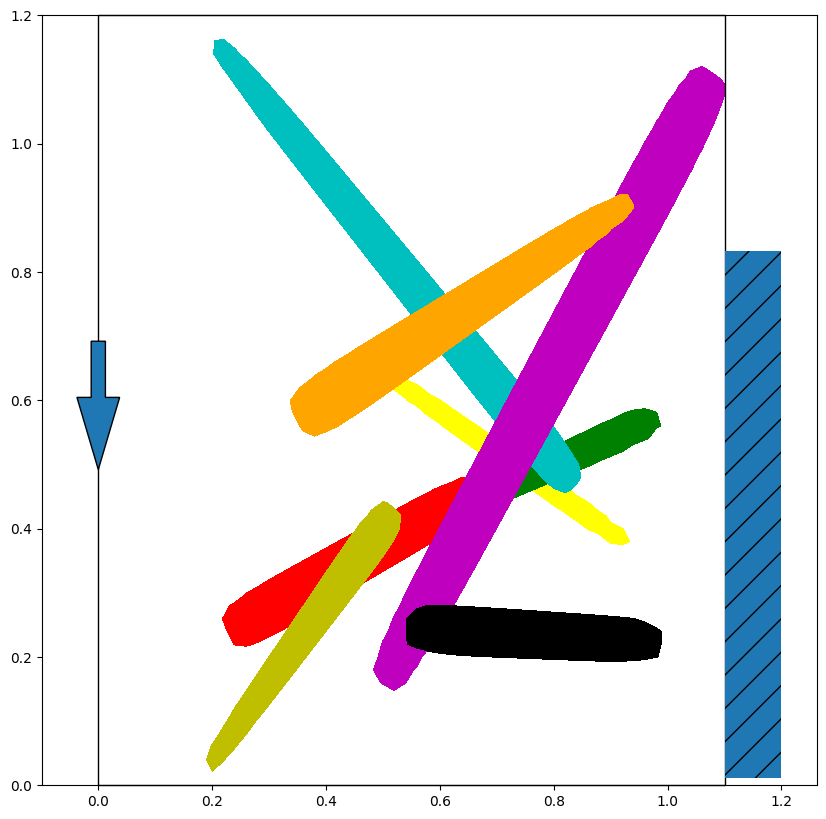

In [7]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done,truncated, info = train_env.step(action)
        
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

(-0.5, 127.5, -0.5, 127.5)

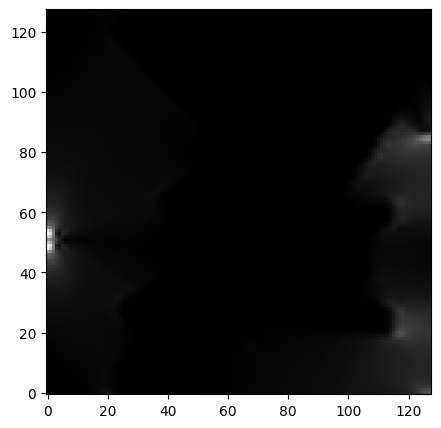

In [21]:
#Show the image: obs['von_mises_stress'] but reshape to go from channel first to channel last:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(obs['von_mises_stress'].transpose(1,2,0),origin='lower',cmap='viridis')
ax.axis('on')

Volume:  0.13674034475775226
Reward  0.0


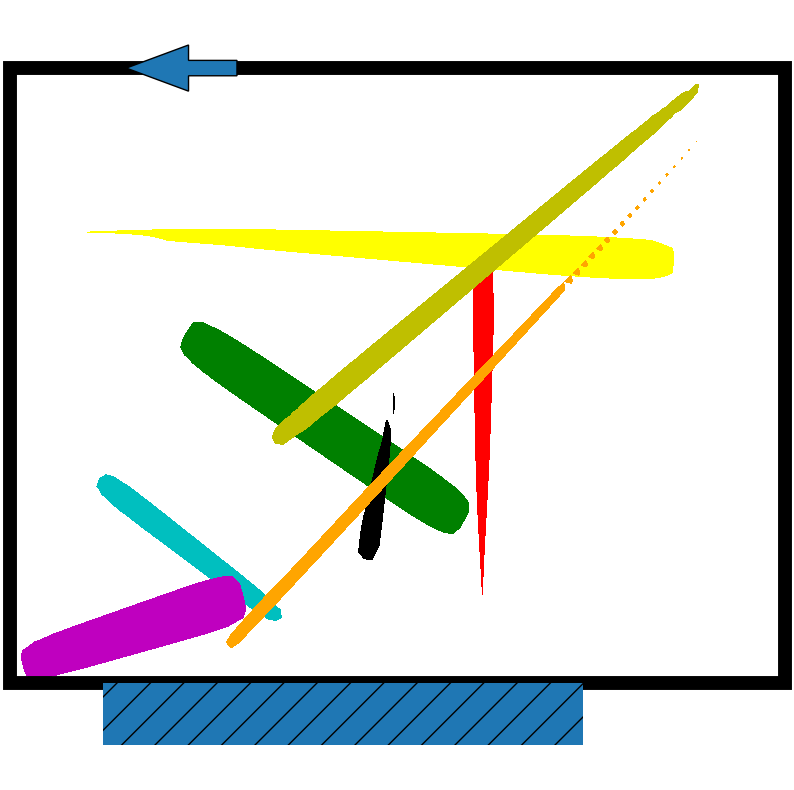

In [5]:
# Let's visualize the eval environment:
obs = eval_env.reset()
done = False
while not done:
    action = eval_env.action_space.sample()
    obs, reward, done, info = eval_env.step(action)
print("Volume: ", eval_env.volume)
print("Reward ",reward)
eval_env.plot()

---
### Multiprocessing

In [65]:
#from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
import multiprocessing

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')

# Set number of cpus to use automatically:
num_cpu = multiprocessing.cpu_count()
train_env = sogym(mode='train',observation_type='dense',vol_constraint_type = 'hard',resolution=150)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type='dense',vol_constraint_type='hard',resolution=150)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


In [66]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

eval_callback = EvalCallback(eval_env,log_path='tb_logs',eval_freq=100,deterministic=True,render=False,verbose=0)
callback = CallbackList([eval_callback,
                         FigureRecorderCallback(check_freq=2*8*32)])

--- 
### Defining the model

In [10]:
from sogym.expert_generation import generate_dataset, generate_all, load_all_trajectories
#generate_dataset(num_threads =16, num_samples=5000,dataset_folder = "dataset/topologies/mmc")
trajectories = load_all_trajectories(n_workers=32)

Loading trajectories: 100%|██████████| 43696/43696 [08:32<00:00, 85.30it/s] 


In [88]:
policy_kwargs = dict(
    net_arch=[2048,2048,2048,2048,2048],
)

In [67]:
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.5 * np.ones(n_actions))

model = SAC("MultiInputPolicy",
             env,
             verbose=0,
             #policy_kwargs = policy_kwargs,
             #action_noise= action_noise,
             tensorboard_log="tb_logs",
             learning_starts=4096,
             batch_size=4096,
             #train_freq = (8, "step"),
             gradient_steps= 1,
             device = 'cuda',
               )

In [84]:
from imitation.algorithms import bc
from imitation.algorithms.adversarial.airl import AIRL
from imitation.rewards.reward_nets import BasicShapedRewardNet
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from imitation.util import logger as imit_logger
import numpy as np

custom_logger = imit_logger.configure(
        folder="imit_tensorboard",
        format_strs=["tensorboard", "stdout"],
    )



In [85]:
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet

#learner=learner.load('checkpoints/SEP_28_BC',env=venv)

reward_net = BasicRewardNet(
    env.observation_space, 
    env.action_space,
    #use_next_state=True,
    #use_done=True,
    #hid_sizes=(128,128),
    #potential_hid_sizes=(32, 32),
    #discount_factor=1.0,
    dropout_prob=0.9
)
reward_net = BasicShapedRewardNet(
    observation_space=env.observation_space,
    action_space=env.action_space,
)


gail_trainer = GAIL(
    demonstrations=trajectories,
    demo_batch_size=4096,
    n_disc_updates_per_round=1,
    venv=env,
    log_dir="imit_tensorboard",
    custom_logger= custom_logger,
    gen_algo=model,
    reward_net=reward_net,
   # disc_opt_kwargs={"weight_decay": 3e-4,
    #                } 
)



In [ ]:
gail_trainer.train(40000000)  # Note: set to 300000 for better results

In [ ]:
#env=sogym(mode='train',observation_type='box_dense',vol_constraint_type='soft')
#learner = learner.load('test_april23',env)
obs=train_env.reset()
dones=False

while dones== False:
    action, _states = model.policy.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones, info = train_env.step(action)
    #print(env.env_method('check_cTypeError: No loop matching the specified signature and casting was found for ufunc greateronnec'))
print("Reward:",rewards)
print('Connected:', train_env.check_connec())
#print('Desired volume:',env.out_conditions[6])
print('Actual volume:',train_env.volume)
fig=train_env.plot()
fig

--- 
### Training

Save the model:

If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

If the environment is normalized:
#env.save('env_saved.pkl')
#env = VecNormalize.load('env_saved.pkl',env)


In [68]:
#model = SAC.load("model_saved_march15",env =env) #Saved model is with soft volume constraint and 75 r
model.set_parameters("model_saved_march15")
#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
#model.learn(20000000,callback=callback,tb_log_name='test_march14_SAC_hardvol')
#model.save('model_saved_march15',)
#model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

c:\Users\thoma\anaconda3\envs\sb3_update\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


---
### Let's visualize the agent's performance:

In [77]:
env=sogym(mode='train',observation_type='dense',vol_constraint_type='hard' ,resolution = 500)
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

Desired volume: 0.41 Obtained volume: 0.39154589865738565
Env reward: 0.20876278298153822 Compliance: 120.31650765407954


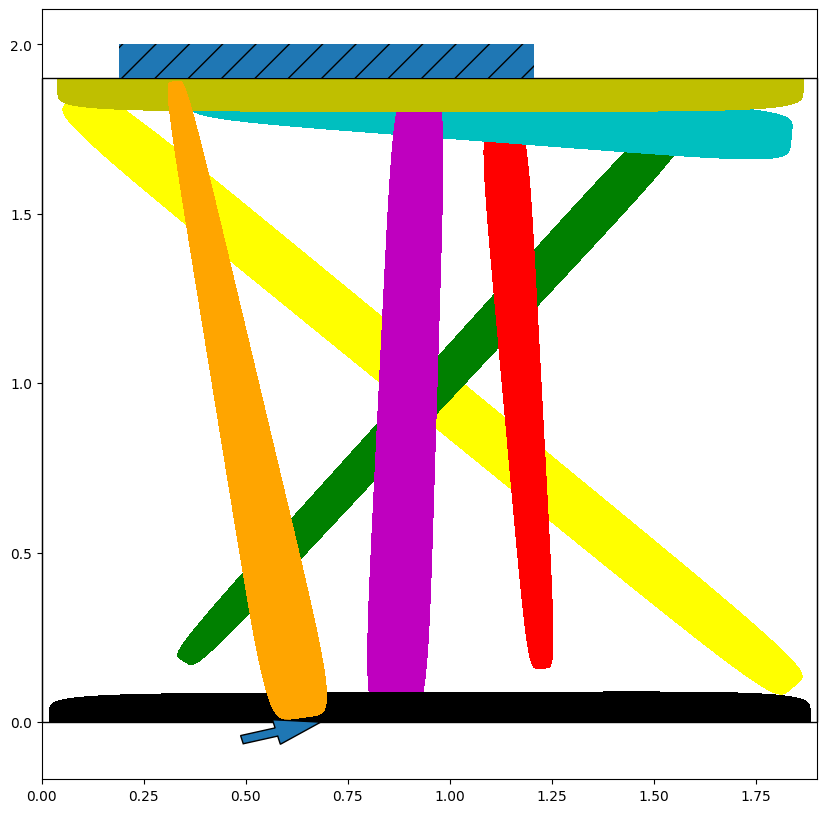

In [78]:
obs,info=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    # print(action)
    obs, rewards, dones,truncated, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
print("Env reward:",rewards, "Compliance:",np.exp(1/rewards))
env.plot()

Text(0.5, 1.0, 'Y-Displacement (Material Presence)')

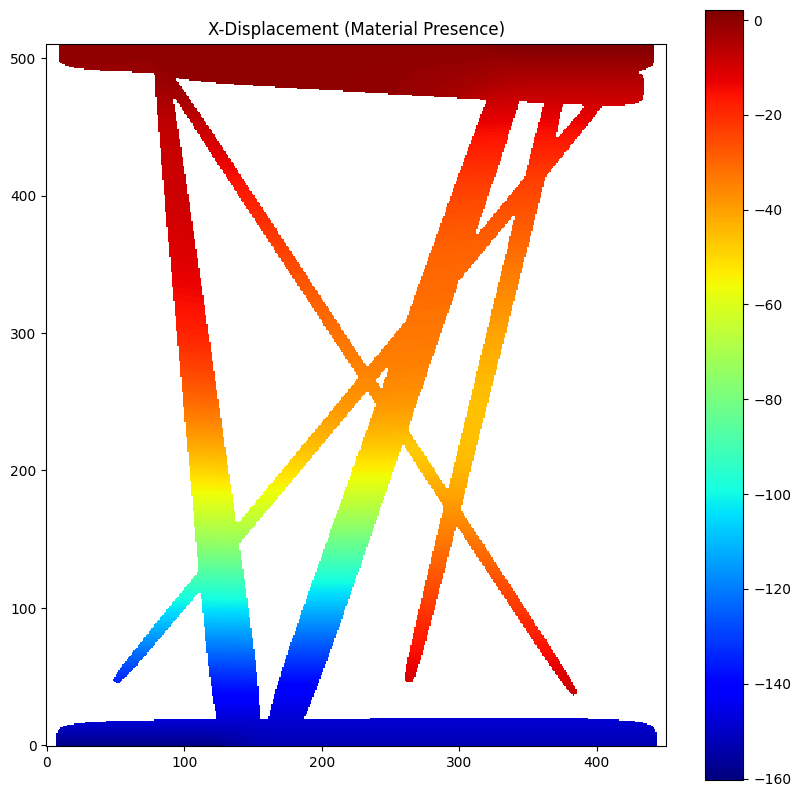

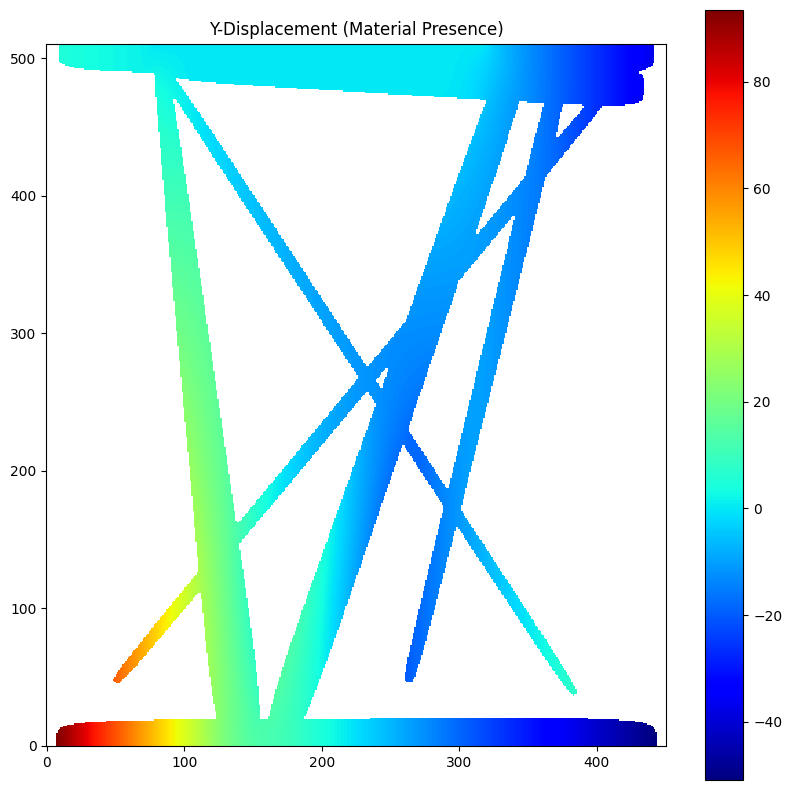

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming env.U, saved_nely, saved_nelx, and env.Phimax are defined elsewhere

nDof = env.U.shape[0]  # Total number of DOFs
nNod = nDof // 2       # Number of nodes

# Create boolean masks for x-displacement and y-displacement DOFs
mask_x = np.arange(nDof) % 2 == 0
mask_y = np.arange(nDof) % 2 == 1

# Extract x-displacement and y-displacement DOFs
x_dofs = env.U[mask_x]
y_dofs = env.U[mask_y]

# Reshape displacement fields to match the structural domain grid
x_displacement = x_dofs.reshape((saved_nely+1, saved_nelx+1), order='F')
y_displacement = y_dofs.reshape((saved_nely+1, saved_nelx+1), order='F')

# Reshape and threshold the material density distribution
density = env.Phimax.reshape((saved_nely+1, saved_nelx+1), order='F')
density = np.where(density < 0.01, 0, 1)  # Binary thresholding

# Use masked arrays to hide regions without material
x_displacement_masked = np.ma.masked_where(density == 0, x_displacement)
y_displacement_masked = np.ma.masked_where(density == 0, y_displacement)

# Plotting x-displacement where there is material
plt.figure()
cmap = plt.cm.jet  # Choose colormap
cmap.set_bad(color='white')  # Set masked values (no material) to white
plt.imshow(x_displacement_masked, cmap=cmap, origin='lower')
plt.colorbar()
plt.title('X-Displacement (Material Presence)')

# Plotting y-displacement where there is material
plt.figure()
plt.imshow(y_displacement_masked, cmap=cmap, origin='lower')
plt.colorbar()
plt.title('Y-Displacement (Material Presence)')


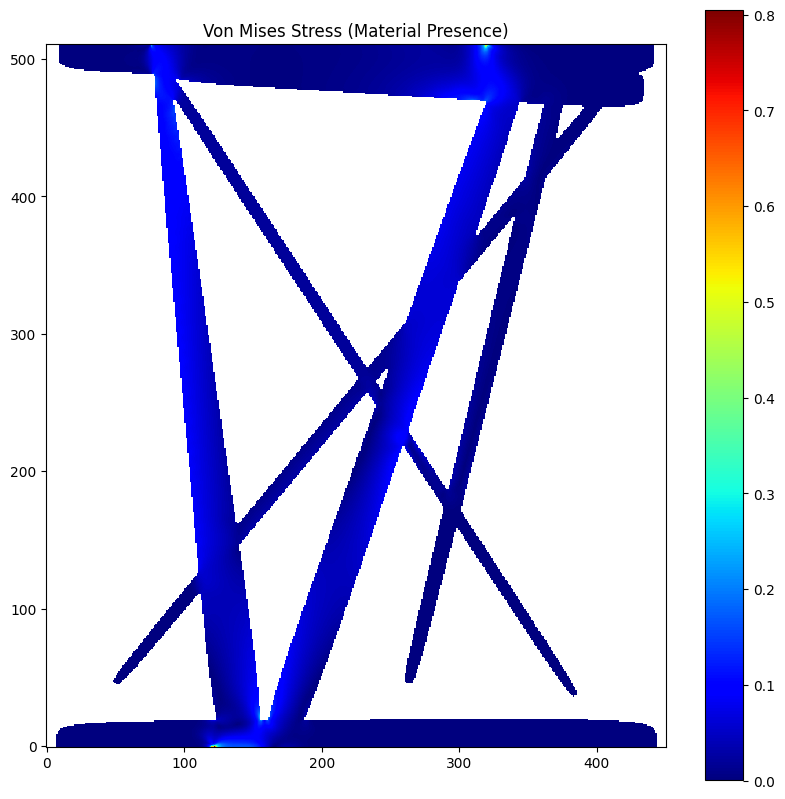

In [76]:
def calculate_strains(x_displacement, y_displacement):
    # Calculate strain fields based on displacement gradients
    strain_xx = np.gradient(x_displacement, axis=1)
    strain_yy = np.gradient(y_displacement, axis=0)
    strain_xy = 0.5 * (np.gradient(x_displacement, axis=0) + np.gradient(y_displacement, axis=1))
    return strain_xx, strain_yy, strain_xy

def calculate_stresses(strain_xx, strain_yy, strain_xy, E=1.0, nu=0.3):
    # Calculate stress fields based on strains and material properties
    stress_xx = E / (1 - nu**2) * (strain_xx + nu * strain_yy)
    stress_yy = E / (1 - nu**2) * (strain_yy + nu * strain_xx)
    stress_xy = E / (2 * (1 + nu)) * strain_xy
    return stress_xx, stress_yy, stress_xy

import numpy as np
import matplotlib.pyplot as plt

# Assuming env.U, saved_nely, saved_nelx, and env.Phimax are defined elsewhere

nDof = env.U.shape[0]  # Total number of DOFs
nNod = nDof // 2       # Number of nodes

# Create boolean masks for x-displacement and y-displacement DOFs
mask_x = np.arange(nDof) % 2 == 0
mask_y = np.arange(nDof) % 2 == 1

# Extract x-displacement and y-displacement DOFs
x_dofs = env.U[mask_x]
y_dofs = env.U[mask_y]

# Reshape displacement fields to match the structural domain grid
x_displacement = x_dofs.reshape((saved_nely+1, saved_nelx+1), order='F')
y_displacement = y_dofs.reshape((saved_nely+1, saved_nelx+1), order='F')

# Reshape and threshold the material density distribution
density = env.Phimax.reshape((saved_nely+1, saved_nelx+1), order='F')
density = np.where(density < 0.01, 0, 1)  # Binary thresholding

# Calculate strain and stress fields
strain_xx, strain_yy, strain_xy = calculate_strains(x_displacement, y_displacement)
stress_xx, stress_yy, stress_xy = calculate_stresses(strain_xx, strain_yy, strain_xy)

# Calculate von Mises stress
von_mises_stress = np.sqrt(stress_xx**2 - stress_xx*stress_yy + stress_yy**2 + 3*stress_xy**2)

# Use masked arrays to hide regions without material
von_mises_stress_masked = np.ma.masked_where(density == 0, von_mises_stress)

# Plotting von Mises stress where there is material
plt.figure()
cmap = plt.cm.jet  # Choose colormap
cmap.set_bad(color='white')  # Set masked values (no material) to white
plt.imshow(von_mises_stress_masked, cmap=cmap, origin='lower')
plt.colorbar()
plt.title('Von Mises Stress (Material Presence)')
plt.show()


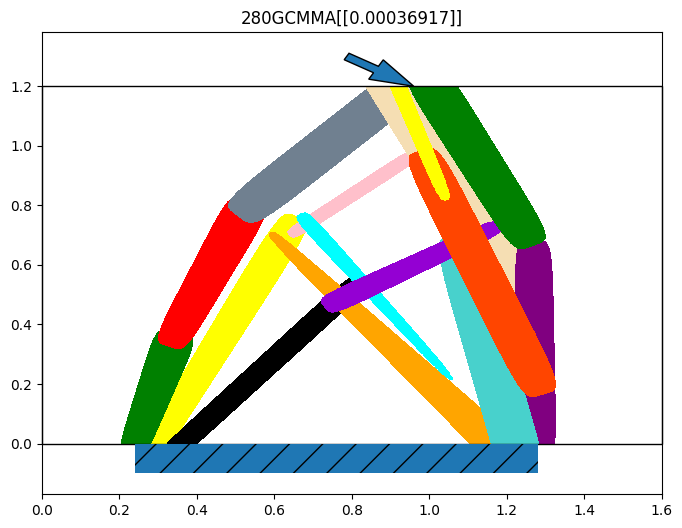

In [17]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')